In [1]:
import torch

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
torch.cuda.is_available()

True

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

def expand_data(dataframe, name):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S+00:00').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

class CustomDataset(Dataset):
    def __init__(self, seq_len=5, max_len=1000, seq = []):
        super(CustomDataset).__init__()
        self.datalist = seq
        self.data, self.targets = self.timeseries(self.datalist, seq_len)

    def __len__(self):
        return len(self.data)

    def timeseries(self, data, window):
        temp = []
        targ = data[window:]
        for i in range(len(data)-window):
            temp.append(data[i:i+window])

        return np.array(temp), targ

    def __getitem__(self, index):
        x = torch.tensor(self.data[index]).type(torch.Tensor)
        y = torch.tensor(self.targets[index]).type(torch.Tensor)
        return x,y


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden states not defnined hence the value of h0,c0 == (0,0)
        out, (hn, cn) = self.lstm(x)

        # as the diagram suggest to take the last output in many to one
        # print(out.shape)
        # print(hn.shape)
        # all batch, last column of seq, all hidden values
        out = out[:, -1, :]
        out = self.fc(out)

        return out



#df = pd.read_csv('station_data_hour_Opatija.csv')


import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 138883"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()




expanded_data = expand_data(df, "name1")
data = expanded_data['utilization']
data_np = data.to_numpy()

train_size = int(len(data_np) * 0.8)
val_size = int(len(data_np) * 0.1)
test_size = len(data_np) - train_size - val_size

train = data_np[:train_size]
val = data_np[train_size:train_size+val_size]
test = data_np[train_size+ val_size:]

train_dataset = CustomDataset(seq_len=64, max_len=len(train), seq = train)
val_dataset = CustomDataset(seq_len=64, max_len=len(val), seq = val)
test_dataset = CustomDataset(seq_len=64, max_len=len(test), seq = test)


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#collate_fn=custom_collector

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = RNN(input_size=1, hidden_size=256, num_layers=4).to(device)

loss_function = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value


for e in tqdm(range(100)):
    model.train()
    total_loss = 0
    for x,y in train_dataloader:
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        x = torch.unsqueeze(x, 0).permute(1,2,0)
        # forward
        predictions = model(x)

        loss = loss_function(predictions.view(-1), y.to(device))

        # backward
        loss.backward()

        # optimization
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_dataloader)


    # Validation
    model.eval()
    val_loss = 0
    predictions_list = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        #h0_val = h0.detach().clone()
        #c0_val = c0.detach().clone()

        for x_val,y_val in val_dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Forward pass with hidden states
            x_val = torch.unsqueeze(x_val, 0).permute(1,2,0)
            predictions = model(x_val)
            #print(predictions.view(-1))
            #print(y_val)
            loss = loss_function(predictions.view(-1), y_val)
            val_loss += loss.item()

            # store predictions
            predictions_list.extend(predictions.cpu().numpy())

    average_val_loss = val_loss / len(val_dataloader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions_list

    print(f'Epoch [{e+1}/{50}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)




       location_id   utilization  connector_count  congested_connectors  \
count      19165.0  19165.000000          19165.0          19165.000000   
mean      138883.0     43.916667              4.0              1.671328   
std            0.0     11.815591              0.0              0.625199   
min       138883.0      0.416667              4.0              0.000000   
25%       138883.0     50.000000              4.0              2.000000   
50%       138883.0     50.000000              4.0              2.000000   
75%       138883.0     50.000000              4.0              2.000000   
max       138883.0     64.583333              4.0              2.000000   

       charging_minutes  
count      19165.000000  
mean         105.400000  
std           28.357418  
min            1.000000  
25%          120.000000  
50%          120.000000  
75%          120.000000  
max          155.000000  
cuda


  1%|▋                                                                         | 1/100 [00:05<09:03,  5.49s/it]

Epoch [1/50], Train Loss: 524.2381, Validation Loss: 285.5098


  2%|█▍                                                                        | 2/100 [00:10<08:34,  5.25s/it]

Epoch [2/50], Train Loss: 305.9142, Validation Loss: 284.5448


  3%|██▏                                                                       | 3/100 [00:15<08:21,  5.17s/it]

Epoch [3/50], Train Loss: 305.7839, Validation Loss: 285.9274


  4%|██▉                                                                       | 4/100 [00:20<08:12,  5.13s/it]

Epoch [4/50], Train Loss: 305.8559, Validation Loss: 286.7046


  5%|███▋                                                                      | 5/100 [00:25<08:05,  5.11s/it]

Epoch [5/50], Train Loss: 305.8980, Validation Loss: 287.1823


  6%|████▍                                                                     | 6/100 [00:30<07:59,  5.10s/it]

Epoch [6/50], Train Loss: 305.9258, Validation Loss: 287.4947


  7%|█████▏                                                                    | 7/100 [00:35<07:53,  5.09s/it]

Epoch [7/50], Train Loss: 305.9452, Validation Loss: 287.7076


  8%|█████▉                                                                    | 8/100 [00:41<07:48,  5.09s/it]

Epoch [8/50], Train Loss: 305.9593, Validation Loss: 287.8574


  9%|██████▋                                                                   | 9/100 [00:46<07:42,  5.09s/it]

Epoch [9/50], Train Loss: 305.9696, Validation Loss: 287.9648


 10%|███████▎                                                                 | 10/100 [00:51<07:37,  5.09s/it]

Epoch [10/50], Train Loss: 305.9774, Validation Loss: 288.0431


 11%|████████                                                                 | 11/100 [00:56<07:32,  5.09s/it]

Epoch [11/50], Train Loss: 305.9830, Validation Loss: 288.1013


 12%|████████▊                                                                | 12/100 [01:01<07:27,  5.08s/it]

Epoch [12/50], Train Loss: 305.9853, Validation Loss: 288.1399


 13%|█████████▍                                                               | 13/100 [01:06<07:22,  5.09s/it]

Epoch [13/50], Train Loss: 233.7751, Validation Loss: 36.0566


 14%|██████████▏                                                              | 14/100 [01:11<07:17,  5.08s/it]

Epoch [14/50], Train Loss: 60.1730, Validation Loss: 45.2248


 15%|██████████▉                                                              | 15/100 [01:16<07:12,  5.09s/it]

Epoch [15/50], Train Loss: 37.5235, Validation Loss: 30.5491


 16%|███████████▋                                                             | 16/100 [01:21<07:07,  5.09s/it]

Epoch [16/50], Train Loss: 28.0554, Validation Loss: 30.3404


 17%|████████████▍                                                            | 17/100 [01:26<07:01,  5.08s/it]

Epoch [17/50], Train Loss: 24.4568, Validation Loss: 26.3864


 18%|█████████████▏                                                           | 18/100 [01:31<06:57,  5.09s/it]

Epoch [18/50], Train Loss: 21.9618, Validation Loss: 24.0448


 19%|█████████████▊                                                           | 19/100 [01:36<06:52,  5.09s/it]

Epoch [19/50], Train Loss: 20.9427, Validation Loss: 23.4276


 20%|██████████████▌                                                          | 20/100 [01:42<06:47,  5.10s/it]

Epoch [20/50], Train Loss: 21.7545, Validation Loss: 24.2795


 21%|███████████████▎                                                         | 21/100 [01:47<06:42,  5.10s/it]

Epoch [21/50], Train Loss: 21.0858, Validation Loss: 25.0275


 22%|████████████████                                                         | 22/100 [01:52<06:37,  5.09s/it]

Epoch [22/50], Train Loss: 20.8368, Validation Loss: 23.8928


 23%|████████████████▊                                                        | 23/100 [01:57<06:32,  5.09s/it]

Epoch [23/50], Train Loss: 25.3664, Validation Loss: 23.0188


 24%|█████████████████▌                                                       | 24/100 [02:02<06:26,  5.09s/it]

Epoch [24/50], Train Loss: 20.0485, Validation Loss: 22.3706


 25%|██████████████████▎                                                      | 25/100 [02:07<06:22,  5.10s/it]

Epoch [25/50], Train Loss: 19.0788, Validation Loss: 22.0187


 26%|██████████████████▉                                                      | 26/100 [02:12<06:16,  5.09s/it]

Epoch [26/50], Train Loss: 18.9819, Validation Loss: 21.5023


 27%|███████████████████▋                                                     | 27/100 [02:17<06:11,  5.09s/it]

Epoch [27/50], Train Loss: 19.1367, Validation Loss: 21.8393


 28%|████████████████████▍                                                    | 28/100 [02:22<06:06,  5.09s/it]

Epoch [28/50], Train Loss: 18.9368, Validation Loss: 21.3971


 29%|█████████████████████▏                                                   | 29/100 [02:27<06:01,  5.09s/it]

Epoch [29/50], Train Loss: 18.9209, Validation Loss: 21.6869


 30%|█████████████████████▉                                                   | 30/100 [02:33<05:56,  5.09s/it]

Epoch [30/50], Train Loss: 18.1373, Validation Loss: 21.4446


 31%|██████████████████████▋                                                  | 31/100 [02:38<05:51,  5.09s/it]

Epoch [31/50], Train Loss: 18.8737, Validation Loss: 21.8532


 32%|███████████████████████▎                                                 | 32/100 [02:43<05:46,  5.10s/it]

Epoch [32/50], Train Loss: 18.5955, Validation Loss: 21.5439


 33%|████████████████████████                                                 | 33/100 [02:48<05:41,  5.10s/it]

Epoch [33/50], Train Loss: 18.7290, Validation Loss: 21.9821


 34%|████████████████████████▊                                                | 34/100 [02:53<05:36,  5.10s/it]

Epoch [34/50], Train Loss: 18.1334, Validation Loss: 21.1846


 35%|█████████████████████████▌                                               | 35/100 [02:58<05:31,  5.10s/it]

Epoch [35/50], Train Loss: 18.4444, Validation Loss: 22.6015


 36%|██████████████████████████▎                                              | 36/100 [03:03<05:26,  5.09s/it]

Epoch [36/50], Train Loss: 18.0850, Validation Loss: 21.1782


 37%|███████████████████████████                                              | 37/100 [03:08<05:20,  5.09s/it]

Epoch [37/50], Train Loss: 18.1319, Validation Loss: 21.1503


 38%|███████████████████████████▋                                             | 38/100 [03:13<05:15,  5.10s/it]

Epoch [38/50], Train Loss: 23.9182, Validation Loss: 25.5696


 39%|████████████████████████████▍                                            | 39/100 [03:18<05:11,  5.11s/it]

Epoch [39/50], Train Loss: 20.4718, Validation Loss: 21.7155


 40%|█████████████████████████████▏                                           | 40/100 [03:24<05:07,  5.13s/it]

Epoch [40/50], Train Loss: 18.1164, Validation Loss: 21.3717


 41%|█████████████████████████████▉                                           | 41/100 [03:29<05:03,  5.14s/it]

Epoch [41/50], Train Loss: 17.8877, Validation Loss: 21.3078


 42%|██████████████████████████████▋                                          | 42/100 [03:34<04:58,  5.14s/it]

Epoch [42/50], Train Loss: 17.7561, Validation Loss: 21.8389


 43%|███████████████████████████████▍                                         | 43/100 [03:39<04:53,  5.15s/it]

Epoch [43/50], Train Loss: 23.7718, Validation Loss: 24.1431


 44%|████████████████████████████████                                         | 44/100 [03:44<04:48,  5.15s/it]

Epoch [44/50], Train Loss: 18.4026, Validation Loss: 21.5535


 45%|████████████████████████████████▊                                        | 45/100 [03:49<04:43,  5.16s/it]

Epoch [45/50], Train Loss: 17.9072, Validation Loss: 21.3368


 46%|█████████████████████████████████▌                                       | 46/100 [03:55<04:38,  5.16s/it]

Epoch [46/50], Train Loss: 17.4587, Validation Loss: 21.0424


 47%|██████████████████████████████████▎                                      | 47/100 [04:00<04:33,  5.16s/it]

Epoch [47/50], Train Loss: 16.9980, Validation Loss: 20.0400


 48%|███████████████████████████████████                                      | 48/100 [04:05<04:28,  5.17s/it]

Epoch [48/50], Train Loss: 17.5441, Validation Loss: 20.9251


 49%|███████████████████████████████████▊                                     | 49/100 [04:10<04:23,  5.17s/it]

Epoch [49/50], Train Loss: 17.1330, Validation Loss: 21.1912


 50%|████████████████████████████████████▌                                    | 50/100 [04:15<04:18,  5.17s/it]

Epoch [50/50], Train Loss: 16.8751, Validation Loss: 20.8096


 51%|█████████████████████████████████████▏                                   | 51/100 [04:20<04:13,  5.17s/it]

Epoch [51/50], Train Loss: 16.8951, Validation Loss: 20.9204


 52%|█████████████████████████████████████▉                                   | 52/100 [04:26<04:08,  5.18s/it]

Epoch [52/50], Train Loss: 16.5831, Validation Loss: 21.1134


 53%|██████████████████████████████████████▋                                  | 53/100 [04:31<04:03,  5.18s/it]

Epoch [53/50], Train Loss: 16.4710, Validation Loss: 20.6990


 54%|███████████████████████████████████████▍                                 | 54/100 [04:36<03:58,  5.17s/it]

Epoch [54/50], Train Loss: 16.6474, Validation Loss: 22.7766


 55%|████████████████████████████████████████▏                                | 55/100 [04:41<03:52,  5.18s/it]

Epoch [55/50], Train Loss: 18.3256, Validation Loss: 20.7881


 56%|████████████████████████████████████████▉                                | 56/100 [04:46<03:47,  5.18s/it]

Epoch [56/50], Train Loss: 16.8594, Validation Loss: 21.7571


 57%|█████████████████████████████████████████▌                               | 57/100 [04:52<03:42,  5.18s/it]

Epoch [57/50], Train Loss: 17.4406, Validation Loss: 21.7711


 58%|██████████████████████████████████████████▎                              | 58/100 [04:57<03:37,  5.18s/it]

Epoch [58/50], Train Loss: 16.7575, Validation Loss: 20.5998


 59%|███████████████████████████████████████████                              | 59/100 [05:02<03:32,  5.18s/it]

Epoch [59/50], Train Loss: 16.3194, Validation Loss: 21.1362


 60%|███████████████████████████████████████████▊                             | 60/100 [05:07<03:26,  5.17s/it]

Epoch [60/50], Train Loss: 16.5476, Validation Loss: 21.3464


 61%|████████████████████████████████████████████▌                            | 61/100 [05:12<03:21,  5.18s/it]

Epoch [61/50], Train Loss: 16.7227, Validation Loss: 20.8156


 62%|█████████████████████████████████████████████▎                           | 62/100 [05:17<03:16,  5.18s/it]

Epoch [62/50], Train Loss: 16.4639, Validation Loss: 20.9974


 63%|█████████████████████████████████████████████▉                           | 63/100 [05:23<03:11,  5.18s/it]

Epoch [63/50], Train Loss: 15.8379, Validation Loss: 20.7941


 64%|██████████████████████████████████████████████▋                          | 64/100 [05:28<03:06,  5.18s/it]

Epoch [64/50], Train Loss: 16.1402, Validation Loss: 20.2723


 65%|███████████████████████████████████████████████▍                         | 65/100 [05:33<03:01,  5.18s/it]

Epoch [65/50], Train Loss: 16.1260, Validation Loss: 20.4272


 66%|████████████████████████████████████████████████▏                        | 66/100 [05:38<02:56,  5.18s/it]

Epoch [66/50], Train Loss: 15.7456, Validation Loss: 20.6001


 67%|████████████████████████████████████████████████▉                        | 67/100 [05:43<02:50,  5.18s/it]

Epoch [67/50], Train Loss: 27.9047, Validation Loss: 22.6731


 68%|█████████████████████████████████████████████████▋                       | 68/100 [05:48<02:45,  5.18s/it]

Epoch [68/50], Train Loss: 17.9333, Validation Loss: 22.3750


 69%|██████████████████████████████████████████████████▎                      | 69/100 [05:54<02:40,  5.18s/it]

Epoch [69/50], Train Loss: 18.8166, Validation Loss: 21.5800


 70%|███████████████████████████████████████████████████                      | 70/100 [05:59<02:35,  5.18s/it]

Epoch [70/50], Train Loss: 17.5556, Validation Loss: 21.3022


 71%|███████████████████████████████████████████████████▊                     | 71/100 [06:04<02:30,  5.18s/it]

Epoch [71/50], Train Loss: 16.6038, Validation Loss: 20.6544


 72%|████████████████████████████████████████████████████▌                    | 72/100 [06:09<02:25,  5.18s/it]

Epoch [72/50], Train Loss: 16.4601, Validation Loss: 21.2346


 73%|█████████████████████████████████████████████████████▎                   | 73/100 [06:14<02:19,  5.18s/it]

Epoch [73/50], Train Loss: 17.6015, Validation Loss: 22.4255


 74%|██████████████████████████████████████████████████████                   | 74/100 [06:20<02:14,  5.18s/it]

Epoch [74/50], Train Loss: 16.9504, Validation Loss: 20.6114


 75%|██████████████████████████████████████████████████████▊                  | 75/100 [06:25<02:09,  5.18s/it]

Epoch [75/50], Train Loss: 22.1691, Validation Loss: 23.2287


 76%|███████████████████████████████████████████████████████▍                 | 76/100 [06:30<02:04,  5.18s/it]

Epoch [76/50], Train Loss: 16.8651, Validation Loss: 21.3591


 77%|████████████████████████████████████████████████████████▏                | 77/100 [06:35<01:59,  5.18s/it]

Epoch [77/50], Train Loss: 16.2761, Validation Loss: 20.6846


 78%|████████████████████████████████████████████████████████▉                | 78/100 [06:40<01:53,  5.18s/it]

Epoch [78/50], Train Loss: 16.6443, Validation Loss: 20.9094


 79%|█████████████████████████████████████████████████████████▋               | 79/100 [06:45<01:48,  5.18s/it]

Epoch [79/50], Train Loss: 15.7995, Validation Loss: 20.4541


 80%|██████████████████████████████████████████████████████████▍              | 80/100 [06:51<01:43,  5.18s/it]

Epoch [80/50], Train Loss: 16.1868, Validation Loss: 21.1657


 81%|███████████████████████████████████████████████████████████▏             | 81/100 [06:56<01:38,  5.18s/it]

Epoch [81/50], Train Loss: 15.9168, Validation Loss: 20.3569


 82%|███████████████████████████████████████████████████████████▊             | 82/100 [07:01<01:33,  5.18s/it]

Epoch [82/50], Train Loss: 15.5155, Validation Loss: 21.1216


 83%|████████████████████████████████████████████████████████████▌            | 83/100 [07:06<01:28,  5.18s/it]

Epoch [83/50], Train Loss: 15.6976, Validation Loss: 20.8366


 84%|█████████████████████████████████████████████████████████████▎           | 84/100 [07:11<01:22,  5.18s/it]

Epoch [84/50], Train Loss: 15.3649, Validation Loss: 21.3373


 85%|██████████████████████████████████████████████████████████████           | 85/100 [07:17<01:17,  5.18s/it]

Epoch [85/50], Train Loss: 15.4482, Validation Loss: 19.0990


 86%|██████████████████████████████████████████████████████████████▊          | 86/100 [07:22<01:12,  5.18s/it]

Epoch [86/50], Train Loss: 15.3387, Validation Loss: 19.5866


 87%|███████████████████████████████████████████████████████████████▌         | 87/100 [07:27<01:07,  5.18s/it]

Epoch [87/50], Train Loss: 15.0224, Validation Loss: 20.7017


 88%|████████████████████████████████████████████████████████████████▏        | 88/100 [07:32<01:02,  5.18s/it]

Epoch [88/50], Train Loss: 16.2254, Validation Loss: 20.4928


 89%|████████████████████████████████████████████████████████████████▉        | 89/100 [07:37<00:56,  5.18s/it]

Epoch [89/50], Train Loss: 15.5480, Validation Loss: 18.7727


 90%|█████████████████████████████████████████████████████████████████▋       | 90/100 [07:42<00:51,  5.18s/it]

Epoch [90/50], Train Loss: 15.4969, Validation Loss: 21.1638


 91%|██████████████████████████████████████████████████████████████████▍      | 91/100 [07:48<00:46,  5.17s/it]

Epoch [91/50], Train Loss: 15.7411, Validation Loss: 21.1172


 92%|███████████████████████████████████████████████████████████████████▏     | 92/100 [07:53<00:41,  5.18s/it]

Epoch [92/50], Train Loss: 15.6970, Validation Loss: 19.9344


 93%|███████████████████████████████████████████████████████████████████▉     | 93/100 [07:58<00:36,  5.18s/it]

Epoch [93/50], Train Loss: 14.9810, Validation Loss: 21.7331


 94%|████████████████████████████████████████████████████████████████████▌    | 94/100 [08:03<00:31,  5.18s/it]

Epoch [94/50], Train Loss: 15.3047, Validation Loss: 20.2891


 95%|█████████████████████████████████████████████████████████████████████▎   | 95/100 [08:08<00:25,  5.18s/it]

Epoch [95/50], Train Loss: 15.0963, Validation Loss: 21.6745


 96%|██████████████████████████████████████████████████████████████████████   | 96/100 [08:14<00:20,  5.18s/it]

Epoch [96/50], Train Loss: 15.6293, Validation Loss: 22.0069


 97%|██████████████████████████████████████████████████████████████████████▊  | 97/100 [08:19<00:15,  5.18s/it]

Epoch [97/50], Train Loss: 15.9835, Validation Loss: 20.0715


 98%|███████████████████████████████████████████████████████████████████████▌ | 98/100 [08:24<00:10,  5.18s/it]

Epoch [98/50], Train Loss: 17.0701, Validation Loss: 23.5933


 99%|████████████████████████████████████████████████████████████████████████▎| 99/100 [08:29<00:05,  5.18s/it]

Epoch [99/50], Train Loss: 15.6988, Validation Loss: 21.1081


100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:34<00:00,  5.15s/it]

Epoch [100/50], Train Loss: 14.8722, Validation Loss: 20.8906
Training finished.
18.772711024139866


<All keys matched successfully>

torch.Size([64, 1])


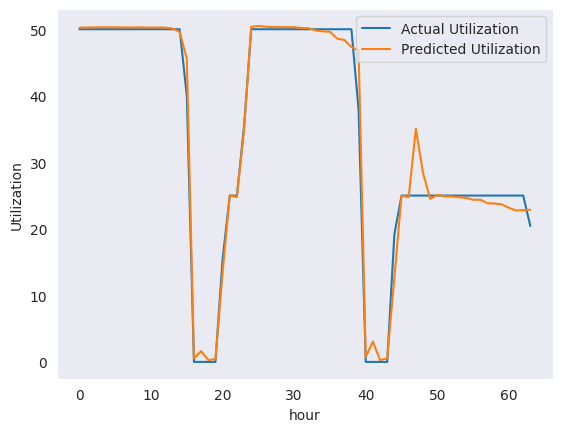

In [2]:
y = []

with torch.no_grad():
  for x_test,y_test in test_dataloader:
      #optimizer.zero_grad()

    x_test, y_test = x_test.to(device), y_test.to(device)
    x_test = torch.unsqueeze(x_test, 0).permute(1,2,0)
    # forward
    predictions = model(x_test)
    break

print(predictions.shape)

plt.plot(np.array(y_test.cpu()), label='Actual Utilization')
plt.plot(np.array(predictions.cpu()), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

def expand_data(dataframe, name):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S+00:00').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

class CustomDataset(Dataset):
    def __init__(self, seq_len=5, max_len=1000, seq = []):
        super(CustomDataset).__init__()
        self.datalist = seq
        self.data, self.targets = self.timeseries(self.datalist, seq_len)

    def __len__(self):
        return len(self.data)

    def timeseries(self, data, window):
        temp = []
        targ = data[window:]
        for i in range(len(data)-window):
            temp.append(data[i:i+window])

        return np.array(temp), targ

    def __getitem__(self, index):
        x = torch.tensor(self.data[index]).type(torch.Tensor)
        y = torch.tensor(self.targets[index]).type(torch.Tensor)
        return x,y


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden states not defnined hence the value of h0,c0 == (0,0)
        out, (hn, cn) = self.lstm(x)

        # as the diagram suggest to take the last output in many to one
        # print(out.shape)
        # print(hn.shape)
        # all batch, last column of seq, all hidden values
        out = out[:, -1, :]
        out = self.fc(out)

        return out



#df = pd.read_csv('station_data_hour_Opatija.csv')


import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 270"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()




expanded_data = expand_data(df, "name1")
data = expanded_data['utilization']
data_np = data.to_numpy()

train_size = int(len(data_np) * 0.8)
val_size = int(len(data_np) * 0.1)
test_size = len(data_np) - train_size - val_size

train = data_np[:train_size]
val = data_np[train_size:train_size+val_size]
test = data_np[train_size+ val_size:]

train_dataset = CustomDataset(seq_len=64, max_len=len(train), seq = train)
val_dataset = CustomDataset(seq_len=64, max_len=len(val), seq = val)
test_dataset = CustomDataset(seq_len=64, max_len=len(test), seq = test)


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#collate_fn=custom_collector

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = RNN(input_size=1, hidden_size=256, num_layers=4).to(device)

loss_function = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value


for e in tqdm(range(100)):
    model.train()
    total_loss = 0
    for x,y in train_dataloader:
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        x = torch.unsqueeze(x, 0).permute(1,2,0)
        # forward
        predictions = model(x)

        loss = loss_function(predictions.view(-1), y.to(device))

        # backward
        loss.backward()

        # optimization
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_dataloader)


    # Validation
    model.eval()
    val_loss = 0
    predictions_list = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        #h0_val = h0.detach().clone()
        #c0_val = c0.detach().clone()

        for x_val,y_val in val_dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Forward pass with hidden states
            x_val = torch.unsqueeze(x_val, 0).permute(1,2,0)
            predictions = model(x_val)
            #print(predictions.view(-1))
            #print(y_val)
            loss = loss_function(predictions.view(-1), y_val)
            val_loss += loss.item()

            # store predictions
            predictions_list.extend(predictions.cpu().numpy())

    average_val_loss = val_loss / len(val_dataloader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions_list

    print(f'Epoch [{e+1}/{50}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)




       location_id   utilization  connector_count  congested_connectors  \
count      16683.0  16683.000000          16683.0          16683.000000   
mean         270.0     19.951410              8.0              1.148175   
std            0.0     10.959625              0.0              0.882489   
min          270.0      0.000000              8.0              0.000000   
25%          270.0     12.500000              8.0              1.000000   
50%          270.0     17.291667              8.0              1.000000   
75%          270.0     25.000000              8.0              2.000000   
max          270.0     62.500000              8.0              5.000000   

       charging_minutes  
count      16683.000000  
mean          95.766769  
std           52.606199  
min            0.000000  
25%           60.000000  
50%           83.000000  
75%          120.000000  
max          300.000000  
cuda


  1%|▋                                                                         | 1/100 [00:05<09:21,  5.67s/it]

Epoch [1/50], Train Loss: 171.6208, Validation Loss: 155.6718


  2%|█▍                                                                        | 2/100 [00:10<08:55,  5.46s/it]

Epoch [2/50], Train Loss: 164.6954, Validation Loss: 155.6646


  3%|██▏                                                                       | 3/100 [00:16<08:42,  5.39s/it]

Epoch [3/50], Train Loss: 164.6655, Validation Loss: 155.6631


  4%|██▉                                                                       | 4/100 [00:21<08:33,  5.35s/it]

Epoch [4/50], Train Loss: 164.6446, Validation Loss: 155.6610


  5%|███▋                                                                      | 5/100 [00:26<08:26,  5.34s/it]

Epoch [5/50], Train Loss: 164.6470, Validation Loss: 155.6620


  6%|████▍                                                                     | 6/100 [00:32<08:20,  5.33s/it]

Epoch [6/50], Train Loss: 164.6419, Validation Loss: 155.6612


  7%|█████▏                                                                    | 7/100 [00:37<08:14,  5.32s/it]

Epoch [7/50], Train Loss: 164.6364, Validation Loss: 155.6607


  8%|█████▉                                                                    | 8/100 [00:42<08:09,  5.32s/it]

Epoch [8/50], Train Loss: 164.6327, Validation Loss: 155.6603


  9%|██████▋                                                                   | 9/100 [00:48<08:04,  5.32s/it]

Epoch [9/50], Train Loss: 164.6299, Validation Loss: 155.6600


 10%|███████▎                                                                 | 10/100 [00:53<07:58,  5.32s/it]

Epoch [10/50], Train Loss: 164.6280, Validation Loss: 155.6598


 11%|████████                                                                 | 11/100 [00:58<07:53,  5.32s/it]

Epoch [11/50], Train Loss: 164.6265, Validation Loss: 155.6597


 12%|████████▊                                                                | 12/100 [01:04<07:47,  5.31s/it]

Epoch [12/50], Train Loss: 164.6255, Validation Loss: 155.6596


 13%|█████████▍                                                               | 13/100 [01:09<07:42,  5.31s/it]

Epoch [13/50], Train Loss: 164.6245, Validation Loss: 155.6595


 14%|██████████▏                                                              | 14/100 [01:14<07:36,  5.31s/it]

Epoch [14/50], Train Loss: 164.6240, Validation Loss: 155.6594


 15%|██████████▉                                                              | 15/100 [01:20<07:31,  5.31s/it]

Epoch [15/50], Train Loss: 164.6237, Validation Loss: 155.6594


 16%|███████████▋                                                             | 16/100 [01:25<07:25,  5.31s/it]

Epoch [16/50], Train Loss: 164.6238, Validation Loss: 155.6593


 17%|████████████▍                                                            | 17/100 [01:30<07:20,  5.31s/it]

Epoch [17/50], Train Loss: 164.6228, Validation Loss: 155.6593


 18%|█████████████▏                                                           | 18/100 [01:35<07:15,  5.31s/it]

Epoch [18/50], Train Loss: 164.6226, Validation Loss: 155.6593


 19%|█████████████▊                                                           | 19/100 [01:41<07:09,  5.30s/it]

Epoch [19/50], Train Loss: 164.6225, Validation Loss: 155.6593


 20%|██████████████▌                                                          | 20/100 [01:46<07:04,  5.30s/it]

Epoch [20/50], Train Loss: 164.6224, Validation Loss: 155.6592


 21%|███████████████▎                                                         | 21/100 [01:51<06:59,  5.30s/it]

Epoch [21/50], Train Loss: 164.6223, Validation Loss: 155.6592


 22%|████████████████                                                         | 22/100 [01:57<06:53,  5.31s/it]

Epoch [22/50], Train Loss: 164.6235, Validation Loss: 155.6592


 23%|████████████████▊                                                        | 23/100 [02:02<06:48,  5.31s/it]

Epoch [23/50], Train Loss: 164.6222, Validation Loss: 155.6592


 24%|█████████████████▌                                                       | 24/100 [02:07<06:43,  5.31s/it]

Epoch [24/50], Train Loss: 164.6222, Validation Loss: 155.6592


 25%|██████████████████▎                                                      | 25/100 [02:13<06:38,  5.31s/it]

Epoch [25/50], Train Loss: 164.6222, Validation Loss: 155.6592


 26%|██████████████████▉                                                      | 26/100 [02:18<06:32,  5.31s/it]

Epoch [26/50], Train Loss: 164.6222, Validation Loss: 155.6592


 27%|███████████████████▋                                                     | 27/100 [02:23<06:27,  5.31s/it]

Epoch [27/50], Train Loss: 164.6383, Validation Loss: 155.6613


 28%|████████████████████▍                                                    | 28/100 [02:28<06:22,  5.31s/it]

Epoch [28/50], Train Loss: 164.6428, Validation Loss: 155.6613


 29%|█████████████████████▏                                                   | 29/100 [02:34<06:16,  5.31s/it]

Epoch [29/50], Train Loss: 164.6430, Validation Loss: 155.6614


 30%|█████████████████████▉                                                   | 30/100 [02:39<06:11,  5.30s/it]

Epoch [30/50], Train Loss: 164.6432, Validation Loss: 155.6614


 31%|██████████████████████▋                                                  | 31/100 [02:44<06:05,  5.30s/it]

Epoch [31/50], Train Loss: 164.6434, Validation Loss: 155.6614


 32%|███████████████████████▎                                                 | 32/100 [02:50<06:00,  5.31s/it]

Epoch [32/50], Train Loss: 164.6435, Validation Loss: 155.6614


 33%|████████████████████████                                                 | 33/100 [02:55<05:55,  5.30s/it]

Epoch [33/50], Train Loss: 164.6436, Validation Loss: 155.6614


 34%|████████████████████████▊                                                | 34/100 [03:00<05:49,  5.30s/it]

Epoch [34/50], Train Loss: 164.6437, Validation Loss: 155.6614


 35%|█████████████████████████▌                                               | 35/100 [03:06<05:44,  5.30s/it]

Epoch [35/50], Train Loss: 164.6437, Validation Loss: 155.6614


 36%|██████████████████████████▎                                              | 36/100 [03:11<05:39,  5.30s/it]

Epoch [36/50], Train Loss: 164.6438, Validation Loss: 155.6614


 37%|███████████████████████████                                              | 37/100 [03:16<05:34,  5.30s/it]

Epoch [37/50], Train Loss: 164.6438, Validation Loss: 155.6614


 38%|███████████████████████████▋                                             | 38/100 [03:22<05:28,  5.30s/it]

Epoch [38/50], Train Loss: 164.6438, Validation Loss: 155.6614


 39%|████████████████████████████▍                                            | 39/100 [03:27<05:23,  5.30s/it]

Epoch [39/50], Train Loss: 164.6438, Validation Loss: 155.6614


 40%|█████████████████████████████▏                                           | 40/100 [03:32<05:18,  5.30s/it]

Epoch [40/50], Train Loss: 164.6439, Validation Loss: 155.6614


 41%|█████████████████████████████▉                                           | 41/100 [03:37<05:12,  5.30s/it]

Epoch [41/50], Train Loss: 164.7089, Validation Loss: 155.7496


 42%|██████████████████████████████▋                                          | 42/100 [03:43<05:07,  5.30s/it]

Epoch [42/50], Train Loss: 164.8922, Validation Loss: 155.6847


 43%|███████████████████████████████▍                                         | 43/100 [03:48<05:02,  5.30s/it]

Epoch [43/50], Train Loss: 164.8846, Validation Loss: 155.6850


 44%|████████████████████████████████                                         | 44/100 [03:53<04:56,  5.30s/it]

Epoch [44/50], Train Loss: 161.9177, Validation Loss: 100.6312


 45%|████████████████████████████████▊                                        | 45/100 [03:59<04:51,  5.30s/it]

Epoch [45/50], Train Loss: 66.9301, Validation Loss: 63.8860


 46%|█████████████████████████████████▌                                       | 46/100 [04:04<04:46,  5.30s/it]

Epoch [46/50], Train Loss: 49.8523, Validation Loss: 61.2511


 47%|██████████████████████████████████▎                                      | 47/100 [04:09<04:41,  5.30s/it]

Epoch [47/50], Train Loss: 47.0740, Validation Loss: 56.5822


 48%|███████████████████████████████████                                      | 48/100 [04:15<04:35,  5.30s/it]

Epoch [48/50], Train Loss: 46.4850, Validation Loss: 56.0256


 49%|███████████████████████████████████▊                                     | 49/100 [04:20<04:30,  5.31s/it]

Epoch [49/50], Train Loss: 46.7406, Validation Loss: 55.2010


 50%|████████████████████████████████████▌                                    | 50/100 [04:25<04:25,  5.31s/it]

Epoch [50/50], Train Loss: 45.3099, Validation Loss: 54.3168


 51%|█████████████████████████████████████▏                                   | 51/100 [04:30<04:19,  5.30s/it]

Epoch [51/50], Train Loss: 44.3519, Validation Loss: 54.2156


 52%|█████████████████████████████████████▉                                   | 52/100 [04:36<04:14,  5.30s/it]

Epoch [52/50], Train Loss: 43.7931, Validation Loss: 53.6199


 53%|██████████████████████████████████████▋                                  | 53/100 [04:41<04:09,  5.31s/it]

Epoch [53/50], Train Loss: 43.7400, Validation Loss: 54.1485


 54%|███████████████████████████████████████▍                                 | 54/100 [04:46<04:04,  5.31s/it]

Epoch [54/50], Train Loss: 43.1099, Validation Loss: 53.2910


 55%|████████████████████████████████████████▏                                | 55/100 [04:52<03:58,  5.31s/it]

Epoch [55/50], Train Loss: 45.2257, Validation Loss: 54.2991


 56%|████████████████████████████████████████▉                                | 56/100 [04:57<03:53,  5.31s/it]

Epoch [56/50], Train Loss: 42.9566, Validation Loss: 54.0346


 57%|█████████████████████████████████████████▌                               | 57/100 [05:02<03:48,  5.31s/it]

Epoch [57/50], Train Loss: 42.5338, Validation Loss: 53.7353


 58%|██████████████████████████████████████████▎                              | 58/100 [05:08<03:42,  5.31s/it]

Epoch [58/50], Train Loss: 42.2641, Validation Loss: 53.7203


 59%|███████████████████████████████████████████                              | 59/100 [05:13<03:37,  5.30s/it]

Epoch [59/50], Train Loss: 41.9176, Validation Loss: 53.3845


 60%|███████████████████████████████████████████▊                             | 60/100 [05:18<03:32,  5.30s/it]

Epoch [60/50], Train Loss: 41.6958, Validation Loss: 53.6940


 61%|████████████████████████████████████████████▌                            | 61/100 [05:24<03:26,  5.30s/it]

Epoch [61/50], Train Loss: 41.4527, Validation Loss: 53.5880


 62%|█████████████████████████████████████████████▎                           | 62/100 [05:29<03:21,  5.30s/it]

Epoch [62/50], Train Loss: 41.1957, Validation Loss: 53.2235


 63%|█████████████████████████████████████████████▉                           | 63/100 [05:34<03:16,  5.30s/it]

Epoch [63/50], Train Loss: 40.8150, Validation Loss: 53.3035


 64%|██████████████████████████████████████████████▋                          | 64/100 [05:39<03:10,  5.30s/it]

Epoch [64/50], Train Loss: 40.6947, Validation Loss: 53.7770


 65%|███████████████████████████████████████████████▍                         | 65/100 [05:45<03:05,  5.30s/it]

Epoch [65/50], Train Loss: 40.4132, Validation Loss: 53.5172


 66%|████████████████████████████████████████████████▏                        | 66/100 [05:50<03:00,  5.30s/it]

Epoch [66/50], Train Loss: 40.1747, Validation Loss: 52.5851


 67%|████████████████████████████████████████████████▉                        | 67/100 [05:55<02:55,  5.30s/it]

Epoch [67/50], Train Loss: 39.9589, Validation Loss: 53.8702


 68%|█████████████████████████████████████████████████▋                       | 68/100 [06:01<02:49,  5.30s/it]

Epoch [68/50], Train Loss: 39.6946, Validation Loss: 54.7062


 69%|██████████████████████████████████████████████████▎                      | 69/100 [06:06<02:44,  5.30s/it]

Epoch [69/50], Train Loss: 39.4401, Validation Loss: 54.6899


 70%|███████████████████████████████████████████████████                      | 70/100 [06:11<02:39,  5.30s/it]

Epoch [70/50], Train Loss: 38.8907, Validation Loss: 55.7294


 71%|███████████████████████████████████████████████████▊                     | 71/100 [06:17<02:33,  5.30s/it]

Epoch [71/50], Train Loss: 38.5818, Validation Loss: 54.5274


 72%|████████████████████████████████████████████████████▌                    | 72/100 [06:22<02:28,  5.30s/it]

Epoch [72/50], Train Loss: 38.3613, Validation Loss: 54.7123


 73%|█████████████████████████████████████████████████████▎                   | 73/100 [06:27<02:23,  5.30s/it]

Epoch [73/50], Train Loss: 38.0448, Validation Loss: 54.9175


 74%|██████████████████████████████████████████████████████                   | 74/100 [06:32<02:17,  5.30s/it]

Epoch [74/50], Train Loss: 37.8858, Validation Loss: 54.9369


 75%|██████████████████████████████████████████████████████▊                  | 75/100 [06:38<02:12,  5.30s/it]

Epoch [75/50], Train Loss: 37.5540, Validation Loss: 56.4359


 76%|███████████████████████████████████████████████████████▍                 | 76/100 [06:43<02:07,  5.30s/it]

Epoch [76/50], Train Loss: 37.1287, Validation Loss: 55.8150


 77%|████████████████████████████████████████████████████████▏                | 77/100 [06:48<02:01,  5.30s/it]

Epoch [77/50], Train Loss: 37.0422, Validation Loss: 55.0776


 78%|████████████████████████████████████████████████████████▉                | 78/100 [06:54<01:56,  5.30s/it]

Epoch [78/50], Train Loss: 36.5126, Validation Loss: 57.9383


 79%|█████████████████████████████████████████████████████████▋               | 79/100 [06:59<01:51,  5.30s/it]

Epoch [79/50], Train Loss: 36.1090, Validation Loss: 57.8517


 80%|██████████████████████████████████████████████████████████▍              | 80/100 [07:04<01:46,  5.30s/it]

Epoch [80/50], Train Loss: 35.8122, Validation Loss: 56.7458


 81%|███████████████████████████████████████████████████████████▏             | 81/100 [07:10<01:40,  5.30s/it]

Epoch [81/50], Train Loss: 36.1908, Validation Loss: 53.4943


 82%|███████████████████████████████████████████████████████████▊             | 82/100 [07:15<01:35,  5.30s/it]

Epoch [82/50], Train Loss: 35.4988, Validation Loss: 56.3075


 83%|████████████████████████████████████████████████████████████▌            | 83/100 [07:20<01:30,  5.30s/it]

Epoch [83/50], Train Loss: 34.5995, Validation Loss: 54.5532


 84%|█████████████████████████████████████████████████████████████▎           | 84/100 [07:25<01:24,  5.30s/it]

Epoch [84/50], Train Loss: 34.0340, Validation Loss: 57.2614


 85%|██████████████████████████████████████████████████████████████           | 85/100 [07:31<01:19,  5.31s/it]

Epoch [85/50], Train Loss: 33.5460, Validation Loss: 58.9304


 86%|██████████████████████████████████████████████████████████████▊          | 86/100 [07:36<01:14,  5.30s/it]

Epoch [86/50], Train Loss: 33.0206, Validation Loss: 60.5132


 87%|███████████████████████████████████████████████████████████████▌         | 87/100 [07:41<01:08,  5.31s/it]

Epoch [87/50], Train Loss: 33.0200, Validation Loss: 62.5822


 88%|████████████████████████████████████████████████████████████████▏        | 88/100 [07:47<01:03,  5.31s/it]

Epoch [88/50], Train Loss: 33.1217, Validation Loss: 57.3514


 89%|████████████████████████████████████████████████████████████████▉        | 89/100 [07:52<00:58,  5.31s/it]

Epoch [89/50], Train Loss: 32.0582, Validation Loss: 58.8295


 90%|█████████████████████████████████████████████████████████████████▋       | 90/100 [07:57<00:53,  5.31s/it]

Epoch [90/50], Train Loss: 31.0540, Validation Loss: 58.2070


 91%|██████████████████████████████████████████████████████████████████▍      | 91/100 [08:03<00:47,  5.31s/it]

Epoch [91/50], Train Loss: 30.2153, Validation Loss: 60.3663


 92%|███████████████████████████████████████████████████████████████████▏     | 92/100 [08:08<00:42,  5.31s/it]

Epoch [92/50], Train Loss: 29.8368, Validation Loss: 60.3182


 93%|███████████████████████████████████████████████████████████████████▉     | 93/100 [08:13<00:37,  5.31s/it]

Epoch [93/50], Train Loss: 29.2674, Validation Loss: 62.5285


 94%|████████████████████████████████████████████████████████████████████▌    | 94/100 [08:19<00:31,  5.32s/it]

Epoch [94/50], Train Loss: 28.9060, Validation Loss: 62.5416


 95%|█████████████████████████████████████████████████████████████████████▎   | 95/100 [08:24<00:26,  5.32s/it]

Epoch [95/50], Train Loss: 28.8823, Validation Loss: 59.8212


 96%|██████████████████████████████████████████████████████████████████████   | 96/100 [08:29<00:21,  5.32s/it]

Epoch [96/50], Train Loss: 27.9901, Validation Loss: 61.1952


 97%|██████████████████████████████████████████████████████████████████████▊  | 97/100 [08:35<00:15,  5.31s/it]

Epoch [97/50], Train Loss: 27.3888, Validation Loss: 63.1148


 98%|███████████████████████████████████████████████████████████████████████▌ | 98/100 [08:40<00:10,  5.31s/it]

Epoch [98/50], Train Loss: 26.4564, Validation Loss: 62.4359


 99%|████████████████████████████████████████████████████████████████████████▎| 99/100 [08:45<00:05,  5.31s/it]

Epoch [99/50], Train Loss: 25.6985, Validation Loss: 64.9135


100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:50<00:00,  5.31s/it]

Epoch [100/50], Train Loss: 25.1961, Validation Loss: 65.2672
Training finished.
52.585062363568476


<All keys matched successfully>

torch.Size([64, 1])


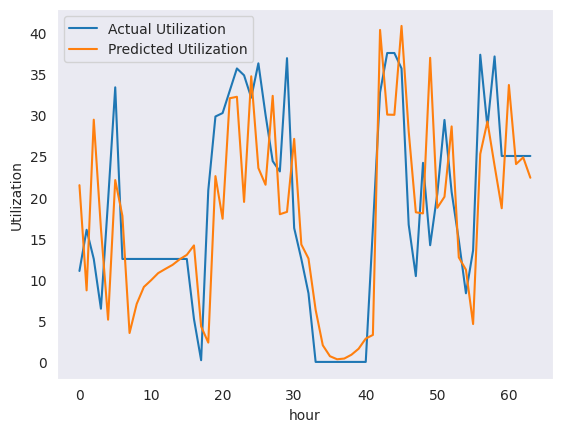

In [9]:
y = []

with torch.no_grad():
  for x_test,y_test in test_dataloader:
      #optimizer.zero_grad()

    x_test, y_test = x_test.to(device), y_test.to(device)
    x_test = torch.unsqueeze(x_test, 0).permute(1,2,0)
    # forward
    predictions = model(x_test)
    break

print(predictions.shape)

plt.plot(np.array(y_test.cpu()), label='Actual Utilization')
plt.plot(np.array(predictions.cpu()), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()

In [7]:
df['location_id'].value_counts()

location_id
138883     19165
270        16683
104028     16245
138889     14072
234        13170
           ...  
133238         2
163380         2
174228         1
1559690        1
1629755        1
Name: count, Length: 270, dtype: int64

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

def expand_data(dataframe, name):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S+00:00').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

class CustomDataset(Dataset):
    def __init__(self, seq_len=5, max_len=1000, seq = []):
        super(CustomDataset).__init__()
        self.datalist = seq
        self.data, self.targets = self.timeseries(self.datalist, seq_len)

    def __len__(self):
        return len(self.data)

    def timeseries(self, data, window):
        temp = []
        targ = data[window:]
        for i in range(len(data)-window):
            temp.append(data[i:i+window])

        return np.array(temp), targ

    def __getitem__(self, index):
        x = torch.tensor(self.data[index]).type(torch.Tensor)
        y = torch.tensor(self.targets[index]).type(torch.Tensor)
        return x,y


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden states not defnined hence the value of h0,c0 == (0,0)
        out, (hn, cn) = self.lstm(x)

        # as the diagram suggest to take the last output in many to one
        # print(out.shape)
        # print(hn.shape)
        # all batch, last column of seq, all hidden values
        out = out[:, -1, :]
        out = self.fc(out)

        return out



#df = pd.read_csv('station_data_hour_Opatija.csv')


import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 270"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()




expanded_data = expand_data(df, "name1")
data = expanded_data['utilization']
data_np = data.to_numpy()

train_size = int(len(data_np) * 0.8)
val_size = int(len(data_np) * 0.1)
test_size = len(data_np) - train_size - val_size

train = data_np[:train_size]
val = data_np[train_size:train_size+val_size]
test = data_np[train_size+ val_size:]

train_dataset = CustomDataset(seq_len=64, max_len=len(train), seq = train)
val_dataset = CustomDataset(seq_len=64, max_len=len(val), seq = val)
test_dataset = CustomDataset(seq_len=64, max_len=len(test), seq = test)


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

       location_id   utilization  connector_count  congested_connectors  \
count      16683.0  16683.000000          16683.0          16683.000000   
mean         270.0     19.951410              8.0              1.148175   
std            0.0     10.959625              0.0              0.882489   
min          270.0      0.000000              8.0              0.000000   
25%          270.0     12.500000              8.0              1.000000   
50%          270.0     17.291667              8.0              1.000000   
75%          270.0     25.000000              8.0              2.000000   
max          270.0     62.500000              8.0              5.000000   

       charging_minutes  
count      16683.000000  
mean          95.766769  
std           52.606199  
min            0.000000  
25%           60.000000  
50%           83.000000  
75%          120.000000  
max          300.000000  


In [21]:
train_dataset.__getitem__(15)

(tensor([12.5000, 12.5000, 12.5000, 12.5000, 12.5000, 12.5000, 12.5000, 12.5000,
         12.5000, 11.2500,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  8.1250, 25.0000, 25.0000, 25.0000,
         16.0417, 12.5000, 12.5000, 12.5000, 12.5000, 12.5000, 12.5000, 12.5000,
         12.5000,  6.0417,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.6250]),
 tensor(18.1250))